In [1]:
from _spark import get_spark, _display
from transformations import transform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import pyspark.sql.functions as f
import pyspark.sql.types as t
import os
import findspark
import pandas as pd

findspark.init()

spark = get_spark()

## BigQuery links

- [BigQuery Table](https://console.cloud.google.com/bigquery?hl=pt-br&project=fiap-tech-challenge-3&ws=!1m0)
- [Storage](https://console.cloud.google.com/storage/browser/tech-challenge;tab=configuration?hl=pt-br&project=fiap-tech-challenge-3&prefix=&forceOnObjectsSortingFiltering=false)
- [IAM e admin](https://console.cloud.google.com/iam-admin/iam?hl=pt-br&project=fiap-tech-challenge-3)

### Refined Data

#### Fato

In [2]:
table_name = "fiap-tech-challenge-3.refined_pnad.tb_f_covid_2020"
df = spark.read \
    .format("bigquery") \
    .option("table", table_name) \
    .load()

_display(df\
            .groupBy('resultado_covid')\
            .agg(f.count('uf'))
            )


Py4JJavaError: An error occurred while calling o39.load.
: com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryException: Error getting access token for service account: 400 Bad Request
POST https://oauth2.googleapis.com/token
{"error":"invalid_grant","error_description":"Invalid JWT Signature."}, iss: fiap-tech-challenge-pyspoark@fiap-tech-challenge-3.iam.gserviceaccount.com
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.translate(HttpBigQueryRpc.java:115)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.getTable(HttpBigQueryRpc.java:300)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl$18.call(BigQueryImpl.java:784)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl$18.call(BigQueryImpl.java:781)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.retrying.DirectRetryingExecutor.submit(DirectRetryingExecutor.java:103)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.RetryHelper.run(RetryHelper.java:76)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.RetryHelper.runWithRetries(RetryHelper.java:50)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl.getTable(BigQueryImpl.java:780)
	at com.google.cloud.bigquery.connector.common.BigQueryClient.getTable(BigQueryClient.java:124)
	at com.google.cloud.bigquery.connector.common.BigQueryClient.getReadTable(BigQueryClient.java:302)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.createRelationInternal(BigQueryRelationProvider.scala:77)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.createRelation(BigQueryRelationProvider.scala:46)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.GoogleAuthException: Error getting access token for service account: 400 Bad Request
POST https://oauth2.googleapis.com/token
{"error":"invalid_grant","error_description":"Invalid JWT Signature."}, iss: fiap-tech-challenge-pyspoark@fiap-tech-challenge-3.iam.gserviceaccount.com
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.GoogleAuthException.createWithTokenEndpointResponseException(GoogleAuthException.java:131)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.ServiceAccountCredentials.refreshAccessToken(ServiceAccountCredentials.java:541)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials$1.call(OAuth2Credentials.java:269)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials$1.call(OAuth2Credentials.java:266)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials$RefreshTask.run(OAuth2Credentials.java:633)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.DirectExecutor.execute(DirectExecutor.java:31)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials$AsyncRefreshResult.executeIfNew(OAuth2Credentials.java:581)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials.asyncFetch(OAuth2Credentials.java:232)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.OAuth2Credentials.getRequestMetadata(OAuth2Credentials.java:182)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.ServiceAccountCredentials.getRequestMetadata(ServiceAccountCredentials.java:938)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.http.HttpCredentialsAdapter.initialize(HttpCredentialsAdapter.java:96)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.http.HttpTransportOptions$1.initialize(HttpTransportOptions.java:159)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.http.HttpRequestFactory.buildRequest(HttpRequestFactory.java:91)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.buildHttpRequest(AbstractGoogleClientRequest.java:442)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.executeUnparsed(AbstractGoogleClientRequest.java:552)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.executeUnparsed(AbstractGoogleClientRequest.java:493)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.execute(AbstractGoogleClientRequest.java:603)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.getTable(HttpBigQueryRpc.java:298)
	... 28 more
Caused by: com.google.cloud.spark.bigquery.repackaged.com.google.api.client.http.HttpResponseException: 400 Bad Request
POST https://oauth2.googleapis.com/token
{"error":"invalid_grant","error_description":"Invalid JWT Signature."}
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.http.HttpResponseException$Builder.build(HttpResponseException.java:293)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.http.HttpRequest.execute(HttpRequest.java:1118)
	at com.google.cloud.spark.bigquery.repackaged.com.google.auth.oauth2.ServiceAccountCredentials.refreshAccessToken(ServiceAccountCredentials.java:538)
	... 45 more


### Trusted Data

#### Fato

In [2]:
table_name = "fiap-tech-challenge-3.trusted_pnad.tb_f_covid_2020"

df = spark.read \
    .format("bigquery") \
    .option("table", table_name) \
    .load()

_display(df\
            .groupBy('resultado_covid')\
            .agg(f.count('uf'))
            )

,resultado_covid,count(uf)
0,Ignorado,2
1,Não,21333
2,Sim,8661
3,Não sabe,174


In [3]:
# Importe as bibliotecas necessárias
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy as np
import seaborn as sns
import geopandas as gpd

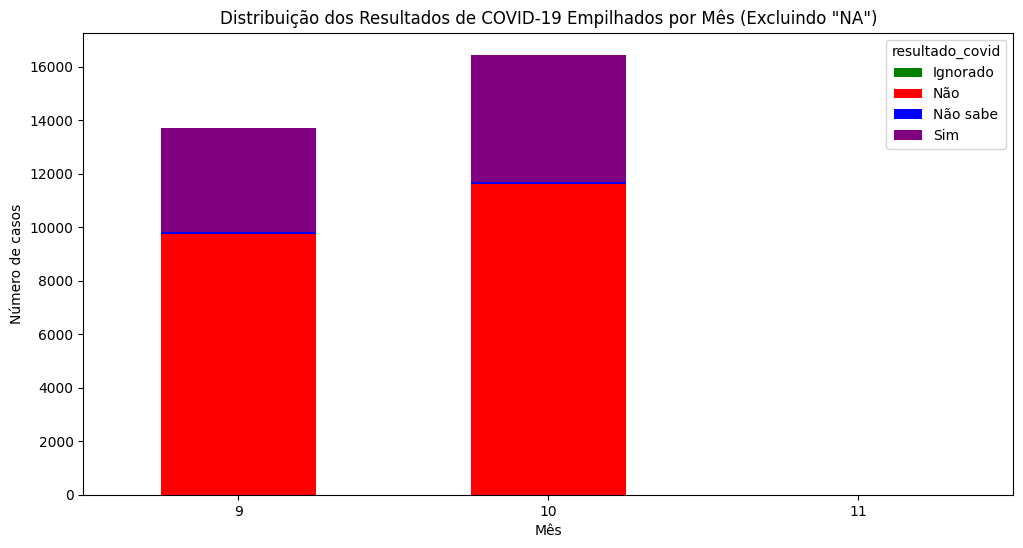

In [6]:
# df = df.toPandas()
# Criando tabela para verificar apenas pesquisas onde os resultados foram diferentes de 'NA'
df_filtrado = df[df['resultado_covid'] != 'NA']

# Criando uma tabela cruzada para contar os resultados por mês.
crosstab = pd.crosstab(df_filtrado['mes'], df_filtrado['resultado_covid'])

# Criando um gráfico empilhado.
crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), color=['green', 'red', 'blue', 'purple'])

plt.title('Distribuição dos Resultados de COVID-19 Empilhados por Mês (Excluindo "NA")')
plt.xlabel('Mês')
plt.ylabel('Número de casos')
plt.xticks(rotation=0)

plt.show()

In [7]:
crosstab

resultado_covid,Ignorado,Não,Não sabe,Sim
mes,,,,
9,2,9728,88,3905
10,0,11604,86,4756
11,0,1,0,0


In [19]:
import plotly.express as px
from plotly import graph_objects as go

fig = px.bar(
    crosstab,
    x=crosstab.index, y=crosstab.columns,
    title="Distribuição dos Resultados de COVID-19 Empilhados por Mês (Excluindo 'NA')"
)
fig.update_layout(
    yaxis=dict(
        title='Número de Casos',
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        title='Mês',
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)
fig.show()

In [11]:
crosstab.index

Index([9, 10, 11], dtype='int64', name='mes')

# Modelo


    r2_score = -0.4929023883561896
    precision_score = 0.4788643533123028
    f1_score = 0.5690721649484536
    roc_auc_score = 0.6957217241609234
    average_precision_score = 0.4220361788883469

    classification_report =               precision    recall  f1-score   support

           0       0.85      0.69      0.76      5334
           1       0.48      0.70      0.57      2165

    accuracy                           0.69      7499
   macro avg       0.66      0.70      0.67      7499
weighted avg       0.74      0.69      0.71      7499




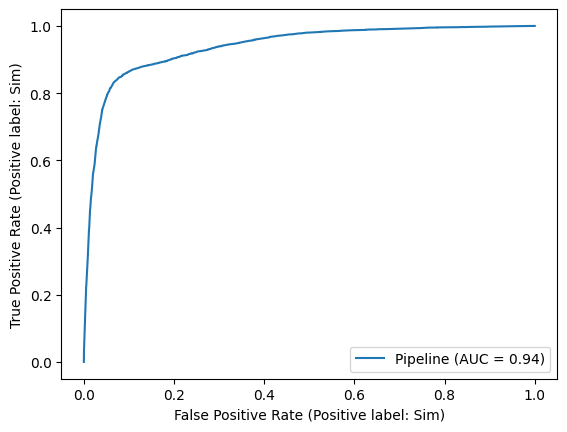

In [14]:
from sklearn.metrics import (  r2_score
                             , precision_score
                             , f1_score
                             , classification_report
                             , roc_auc_score
                             , precision_recall_curve
                             , average_precision_score
                             , RocCurveDisplay
                             )
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import pandas as pd

table_name = "fiap-tech-challenge-3.trusted_pnad.tb_f_covid_2020"
query = """
    select 
          resultado_covid
        , uf
        , area_domicilio
        , idade
        , sexo
        , cor_raca
        , escolaridade
        , tem_plano_saude
        , situacao_domicilio
        , teve_febre
        , teve_dificuldade_respirar
        , teve_dor_cabeca
        , teve_fadiga
        , teve_perda_cheiro
    from
        df_spark
    where
        resultado_covid in ('Sim','Não')
    """
df = spark.read\
    .format("bigquery")\
    .option("table", table_name)\
    .load()\
    .createOrReplaceTempView('df_spark')

df = spark\
    .sql(query)\
    .toPandas()

_features = list(set(df.columns) - set(['resultado_covid']))

transform_pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist'))
    ]
)

pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
        ('model',RandomForestClassifier(random_state=42))
    ]
)

X = df[_features]
y = df[['resultado_covid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

model = pipeline['model']
y_pred = pipeline.predict(X_test)

_y_test = [int(x.replace('Não','0').replace('Sim','1')) for x in y_test['resultado_covid'].to_list()]
_y_pred = [int(x.replace('Não','0').replace('Sim','1')) for x in y_pred]

print(f"""
    r2_score = {r2_score(_y_test, _y_pred)}
    precision_score = {precision_score(_y_test, _y_pred)}
    f1_score = {f1_score(_y_test, _y_pred)}
    roc_auc_score = {roc_auc_score(_y_test, _y_pred)}
    average_precision_score = {average_precision_score(_y_test, _y_pred)}

    classification_report = {classification_report(_y_test, _y_pred)}
""")

RocCurveDisplay.from_estimator(pipeline, X, y)

result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.DataFrame([result.importances_mean, X.columns], index=['importance','feature']).T


fig = px.bar(
    forest_importances.sort_values('importance'),
    x='importance', y='feature', orientation='h'
)

fig.update_layout(
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)

fig.show()

---


r2_score = -1.1357790149210558
precision_score = 0.3319377990430622
f1_score = 0.40297694681430385
roc_auc_score = 0.5469397156764181
average_precision_score = 0.3108706242326724

classification_report =               precision    recall  f1-score   support

           0       0.75      0.58      0.65      5334
           1       0.33      0.51      0.40      2165

    accuracy                           0.56      7499
   macro avg       0.54      0.55      0.53      7499
weighted avg       0.63      0.56      0.58      7499




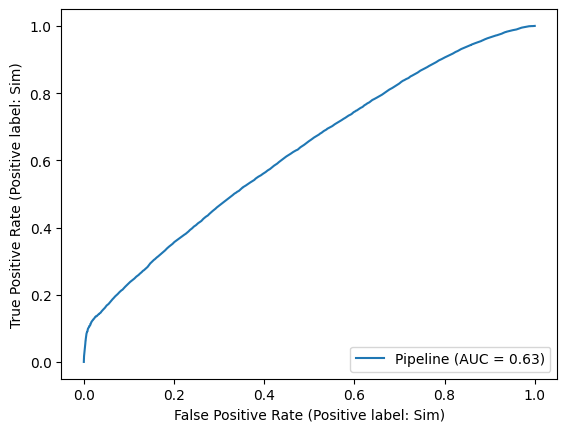

In [15]:
from sklearn.metrics import (  r2_score
                             , precision_score
                             , f1_score
                             , classification_report
                             , roc_auc_score
                             , precision_recall_curve
                             , average_precision_score
                             , RocCurveDisplay
                             )
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import pandas as pd

table_name = "fiap-tech-challenge-3.trusted_pnad.tb_f_covid_2020"
query = """
    select 
          resultado_covid
        , idade
        , sexo
        , tem_plano_saude
        , teve_febre
        , teve_dificuldade_respirar
        , teve_dor_cabeca
        , teve_fadiga
        , teve_perda_cheiro
    from
        df_spark
    where
        resultado_covid in ('Sim','Não')
    """
df = spark.read\
    .format("bigquery")\
    .option("table", table_name)\
    .load()\
    .createOrReplaceTempView('df_spark')

df = spark\
    .sql(query)\
    .toPandas()

_features = list(set(df.columns) - set(['resultado_covid']))

transform_pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist'))
    ]
)

pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
        ('model',RandomForestClassifier(random_state=42))
    ]
)

X = df[_features]
y = df[['resultado_covid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

model = pipeline['model']
y_pred = pipeline.predict(X_test)

_y_test = [int(x.replace('Não','0').replace('Sim','1')) for x in y_test['resultado_covid'].to_list()]
_y_pred = [int(x.replace('Não','0').replace('Sim','1')) for x in y_pred]

print(f"""
r2_score = {r2_score(_y_test, _y_pred)}
precision_score = {precision_score(_y_test, _y_pred)}
f1_score = {f1_score(_y_test, _y_pred)}
roc_auc_score = {roc_auc_score(_y_test, _y_pred)}
average_precision_score = {average_precision_score(_y_test, _y_pred)}

classification_report = {classification_report(_y_test, _y_pred)}
""")

RocCurveDisplay.from_estimator(pipeline, X, y)

result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.DataFrame([result.importances_mean, X.columns], index=['importance','feature']).T


fig = px.bar(
    forest_importances.sort_values('importance'),
    x='importance', y='feature', orientation='h'
)
fig.update_layout(
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)
fig.show()

---

In [ ]:
import plotly.express as px

_df = transform_pipeline.fit_transform(X, y)
_columns = transform_pipeline.get_feature_names_out()

fig = px.imshow(
    pd.DataFrame.sparse.from_spmatrix(_df, columns=_columns).corr()
    , text_auto=True, aspect="auto")
fig.show()